## 1. Introduction

The project's primary objective is to develop a robust credit risk assessment ML model utilizing the [Kaggle Dataset](<https://www.kaggle.com/datasets/laotse/credit-risk-dataset>), enabling the prediction of loan default likelihood based on diverse applicant features. While the current focus of the notebook is specifically on the ML workflow for model development, the ultimate aim is to expose the model as a containerized API. This API integration will empower internal bank applications and systems to seamlessly request credit risk assessments for loan applicants. By leveraging the model's accurate predictions, the bank can make efficient and well-informed lending decisions, minimizing financial losses, and reinforcing the overall financial stability of the institution.

## 2. Methodology

The project follows a typical machine learning workflow consisting of exploratory data analysis (EDA), data splitting, preprocessing, modeling, and evaluation. Additionally, a comparison of tree-based algorithms, including Random Forest, XGBoost, LightGBM, and a Deep Neural Network (DNN), was performed to determine the winning model.

## 3. Development of Credit Risk Prediction Model

### 3.1 Import Libraries

In [1]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Data Preprocessing and Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Model Evaluation and Metrics
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import roc_curve, roc_auc_score

# Model Training and Tuning
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

# Model Persistence and Loading
from tensorflow.keras.models import load_model
from joblib import dump, load

### 3.2 Data Collection

The dataset containing diverse applicant features is collected as the initial step.

In [2]:
# Read the CSV file and store it as a DataFrame
df = pd.read_csv('data/credit_risk_dataset.csv')

print(df.shape)
df.head()

(32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


### 3.3 Exploratory Data Analysis (EDA)

EDA is conducted to gain insights into the dataset, identify patterns, and understand the relationships between attributes and insurance charges. This analysis provides valuable information for model building.

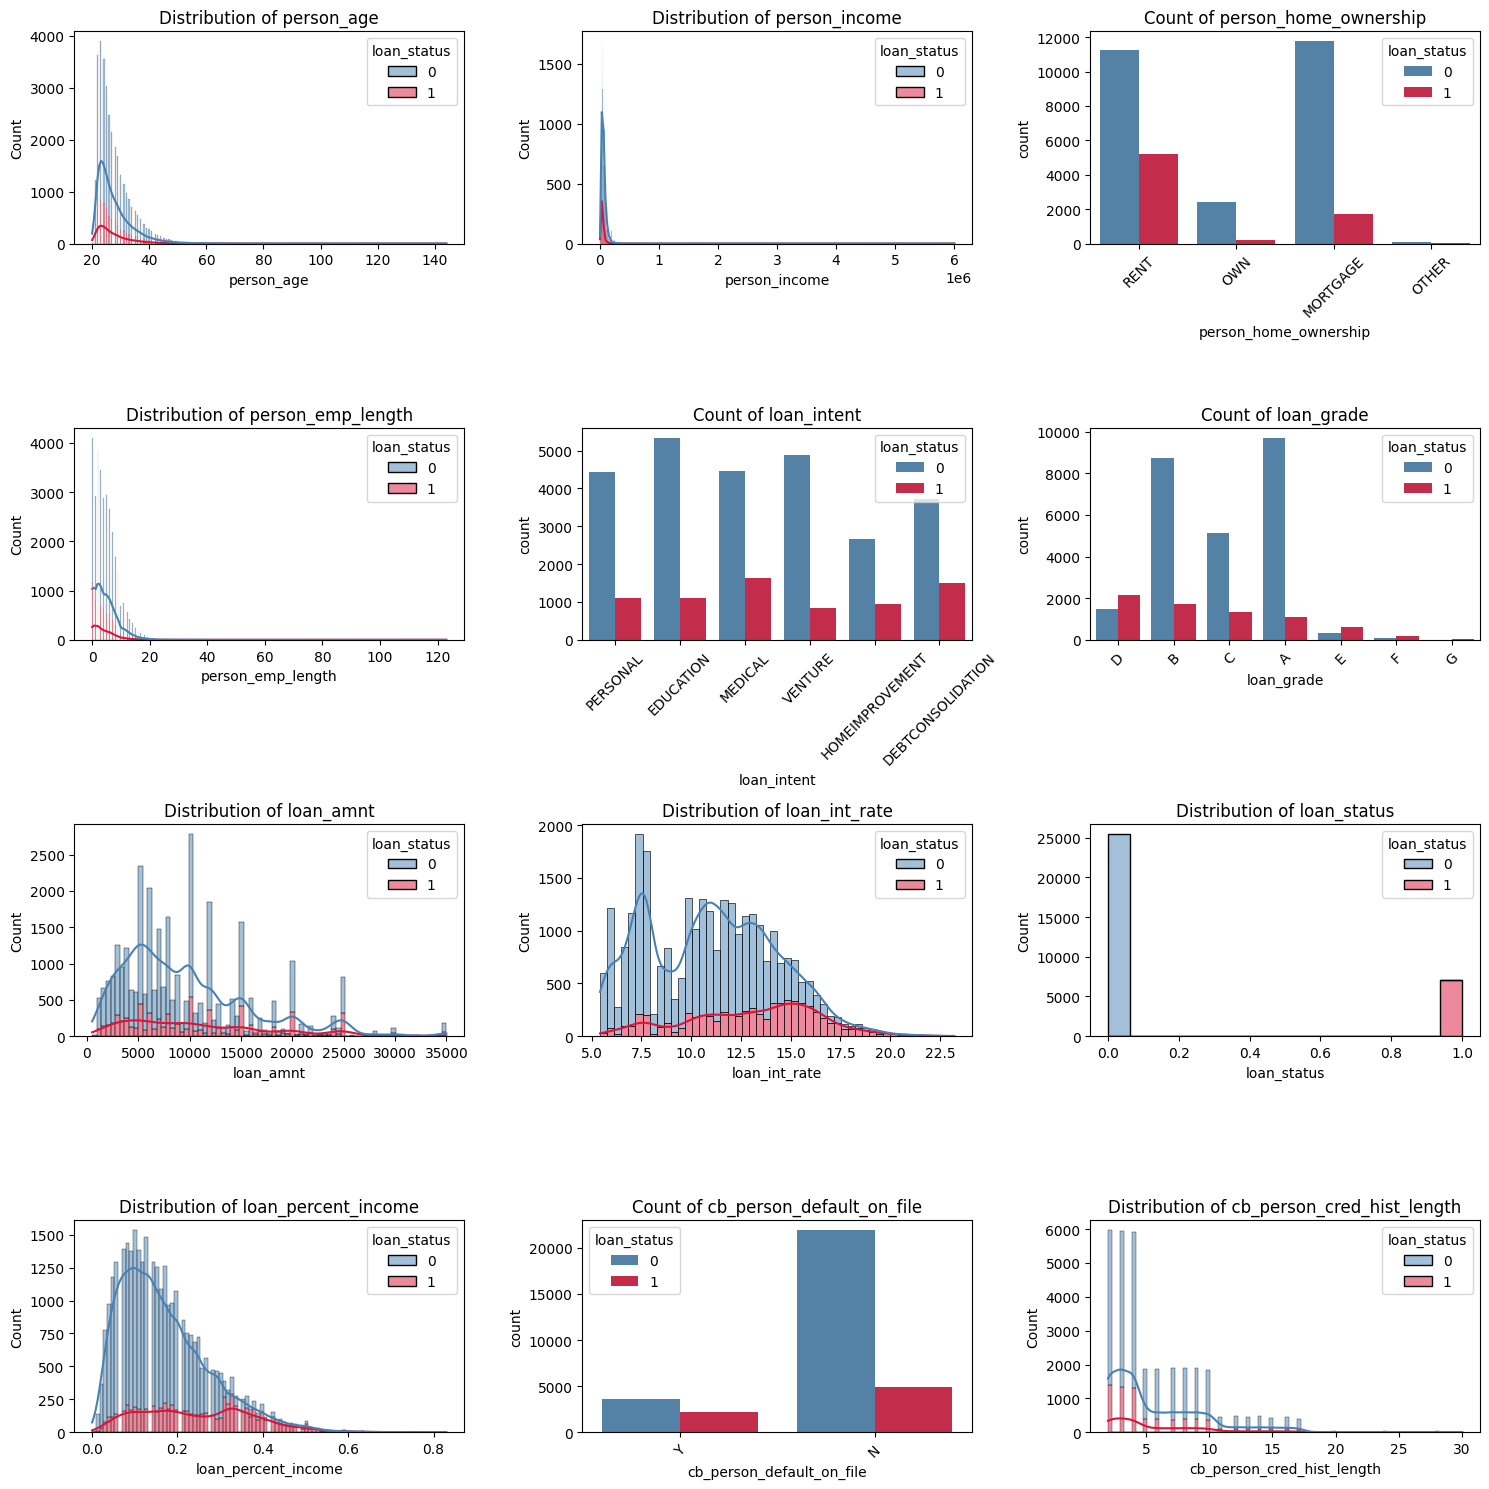

In [3]:
# Create a figure and axes for subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 15))

# Set the desired color palette
color_palette = ['steelblue', 'crimson']

# Iterate over the columns of the DataFrame
for i, column in enumerate(df.columns):
    # Determine the position of the subplot in the grid
    row = i // 3
    col = i % 3
    
    # Check if the current column is numerical
    if df[column].dtype == 'float64' or df[column].dtype == 'int64':
        # Plot a histogram for numerical features
        sns.histplot(data=df, x=column, kde=True, hue='loan_status', multiple='stack', palette=color_palette, ax=axes[row, col])
        axes[row, col].set_title(f'Distribution of {column}')
        axes[row, col].tick_params(axis='x')  # Rotate x-axis labels if needed
    else:
        # Plot a barplot for categorical features
        sns.countplot(data=df, x=column, hue='loan_status', palette=color_palette, ax=axes[row, col])
        axes[row, col].set_title(f'Count of {column}')
        axes[row, col].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed
        
# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

### 3.4 Data Splitting

The dataset is divided into two sets: the training set and the testing set. The training set is utilized to train and validate the ML models developed using different algorithms, employing n-fold cross-validation to ensure robustness. On the other hand, the testing set is employed to assess the model's performance on unseen data, providing an objective evaluation of its predictive capabilities.

In [4]:
# Separate the features (X) and the target variable (y)
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

train_size = 0.80
test_size = 1-train_size

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print("Train Set: ", train_size)
print("Train Records Count: ", X_train.shape[0])
print("Test Set: ", round(test_size,1))
print("Test Records Count: ", X_test.shape[0])

Train Set:  0.8
Train Records Count:  26064
Test Set:  0.2
Test Records Count:  6517


### 3.5 Data Preprocessing

Data preprocessing involves several steps, including data cleaning, encoding categorical variables, and scaling numerical features. 

In [5]:
X_train_numerical = X_train.select_dtypes(include=['float64', 'int64'])
X_train_categorical = X_train.select_dtypes(include=['object'])
X_test_numerical = X_test.select_dtypes(include=['float64', 'int64'])
X_test_categorical = X_test.select_dtypes(include=['object'])

#### Data Cleaning

Data cleaning plays a crucial role in preparing the dataset for analysis by addressing inconsistencies, missing values, duplicates, and ensuring data accuracy. In our specific dataset, which includes missing numerical values, we employ missing mean imputation to handle these missing values, ensuring a complete and reliable dataset for further analysis.

In [6]:
# check count of missing values
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [7]:
# Create an instance of SimpleImputer for numerical features
num_imputer = SimpleImputer(strategy='mean')

# Fit-transform on the training set
X_train_imputed = pd.DataFrame(num_imputer.fit_transform(X_train_numerical), columns=X_train_numerical.columns, index=X_train_numerical.index)

# Transform on the test set
X_test_imputed = pd.DataFrame(num_imputer.transform(X_test_numerical), columns=X_test_numerical.columns, index=X_test_numerical.index)

#### Feature Scaling - Standard Scaling

Numerical features are scaled using the standard scaler, ensuring that all numerical variables are transformed to have a mean of 0 and a standard deviation of 1. This normalization process enhances the performance of machine learning models and prevents features with larger scales from dominating the analysis.

In [8]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on X_train_imputed
scaler.fit(X_train_imputed)

# Transform X_train_imputed and X_test using the fitted scaler
X_train_scaled = scaler.transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_numerical.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train_numerical.columns)

#### Feature Encoding - One Hot Encoding

Categorical variables are encoded using one-hot encoding, allowing for the representation of categorical data as binary vectors and enabling machine learning algorithms to effectively utilize this information.

In [9]:
# Create an instance of OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder on X_train_categorical
encoder.fit(X_train_categorical)

# Transform X_train_categorical and X_test_categorical using the fitted encoder
X_train_encoded = encoder.transform(X_train_categorical)
X_test_encoded = encoder.transform(X_test_categorical)

# Convert the encoded arrays back to DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(X_train_categorical.columns))
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(X_test_categorical.columns))

#### Concatenate DataFrames

The scaled and encoded dataframes for the train, and test sets are concatenated together, creating merged datasets that contain both the transformed categorical variables (encoded) and normalized numerical variables (scaled).

In [10]:
# Combine the numerical and categorical DataFrames
X_train_processed = pd.concat([X_train_scaled_df, X_train_encoded_df], axis=1)
X_test_processed = pd.concat([X_test_scaled_df, X_test_encoded_df], axis=1)

#### Handling Imbalanced Dataset

Imbalanced dataset handling is crucial in machine learning, and one effective technique is Synthetic Minority Over-sampling Technique (SMOTE), which generates synthetic samples of the minority class to balance the dataset, improving model performance and accuracy in predicting rare events.

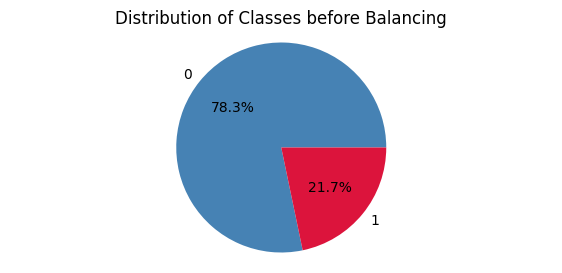

In [11]:
# Count the occurrences of 0 and 1
value_counts = y_train.value_counts()

# Define custom colors using Seaborn's color palette
colors = sns.color_palette(['steelblue', 'crimson'])

# Create a figure with a specific size
fig, ax = plt.subplots(figsize=(7, 3))

# Create a pie chart
plt.pie(value_counts, labels=value_counts.index, colors=colors, autopct='%1.1f%%')

# Set the aspect ratio to be equal to make the pie circular
plt.axis('equal')

# Add a title
plt.title('Distribution of Classes before Balancing')

# Display the plot
plt.show()

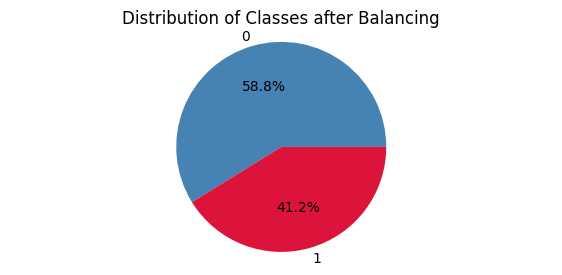

In [12]:
# Create an instance of SMOTE
smote = SMOTE(sampling_strategy=0.7)  # Generate synthetic samples for the minority class to achieve a 1:2 ratio

# Apply SMOTE to the training data
X_train_processed, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Count the occurrences of each class in the resampled dataset
value_counts_resampled = y_train_resampled.value_counts()

# Define custom colors using Seaborn's color palette
colors = sns.color_palette(['steelblue', 'crimson'])

# Create a figure with a specific size
fig, ax = plt.subplots(figsize=(7, 3))

# Create a pie chart
plt.pie(value_counts_resampled, labels=value_counts_resampled.index, colors=colors, autopct='%1.1f%%')

# Set the aspect ratio to be equal to make the pie circular
plt.axis('equal')

# Add a title
plt.title('Distribution of Classes after Balancing')

# Display the plot
plt.show()

### 3.6 Modeling and Evaluation

In the modeling and evaluation phase, the performance of Random Forest, LightGBM, XGBoost, and DNN models is compared. These models are assessed based on AUC-ROC score to determine the most suitable model for credit risk assessment in terms of predictive power and generalization capability.

#### Ensemble Learning

The given code snippet defines a dictionary of classifiers including Random Forest (RF), LightGBM (LGBM), and XGBoost (XGB), along with their respective hyperparameter grids. The code then performs stratified k-fold cross-validation, optimizing the hyperparameters using RandomizedSearchCV to find the best configuration for each classifier based on the ROC-AUC metric for the train set. Subsequently, the trained models are evaluated on the test set to assess their performance on unseen data.

In [13]:
classifiers = {
    'RF': {
        'classifier': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'LGBM': {
        'classifier': lgb.LGBMClassifier(),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 10],
            'learning_rate': [0.01, 0.1, 0.5]
        }
    },
    'XGB': {
        'classifier': xgb.XGBClassifier(),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 10],
            'learning_rate': [0.01, 0.1, 0.5]
        }
    }
}

# Initialize the stratified k-fold cross-validation
n_folds = 3
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

train_scores = []
test_scores = []

for clf_name, clf_info in classifiers.items():

    random_search = RandomizedSearchCV(
        estimator=clf_info['classifier'],
        param_distributions=clf_info['param_grid'],
        n_iter=3,
        scoring='roc_auc',
        n_jobs=-1,
        cv=skf,
        refit=True
    )
    random_search.fit(X_train_processed, y_train_resampled)

    print(clf_name)
    print("Best hyperparameters: ", random_search.best_params_)

    train_score = random_search.best_score_
    print("Train score: ", train_score)

    y_pred_test = random_search.predict(X_test_processed)
    test_score = roc_auc_score(y_test, y_pred_test)
    print("Test set score: ", test_score)
    print()

    train_scores.append(train_score)
    test_scores.append(test_score)

RF
Best hyperparameters:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}
Train score:  0.9450978987729312
Test set score:  0.848472583039525

LGBM
Best hyperparameters:  {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.5}
Train score:  0.9760222598609835
Test set score:  0.8615631788065012

XGB
Best hyperparameters:  {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1}
Train score:  0.9789022706278425
Test set score:  0.8597729034089049



#### Deep Learning

The code snippet defines a neural network architecture using TensorFlow's Keras API, consisting of several dense layers with ReLU activation and a sigmoid output layer. The model is compiled with binary cross-entropy loss and the Adam optimizer. The model is then evaluated using stratified k-fold cross-validation, calculating the ROC AUC scores for both the train and test sets. The average scores are computed and printed as the performance evaluation of the deep neural network (DNN) model.

In [14]:
# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with the appropriate loss function and optimizer
model.compile(loss='binary_crossentropy', optimizer='adam')

# Train the model on the training set
model.fit(X_train_processed, y_train_resampled, epochs=30, batch_size=12, verbose=1)

# Predict probabilities for train and test sets
y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)

# Calculate ROC AUC scores for train and test sets
DNN_train_score = roc_auc_score(y_train_resampled, y_train_pred)
DNN_test_score = roc_auc_score(y_test, y_test_pred)

# Print the scores
print("Train set score: ", DNN_train_score)
print("Test set score: ", DNN_test_score)

Epoch 1/30
2891/2891 [==============================] - 3s 753us/step - loss: 0.3686
Epoch 2/30
2891/2891 [==============================] - 2s 750us/step - loss: 0.3131
Epoch 3/30
2891/2891 [==============================] - 2s 767us/step - loss: 0.2984
Epoch 4/30
2891/2891 [==============================] - 2s 731us/step - loss: 0.2872
Epoch 5/30
2891/2891 [==============================] - 2s 752us/step - loss: 0.2797
Epoch 6/30
2891/2891 [==============================] - 2s 760us/step - loss: 0.2735
Epoch 7/30
2891/2891 [==============================] - 2s 733us/step - loss: 0.2667
Epoch 8/30
2891/2891 [==============================] - 2s 738us/step - loss: 0.2604
Epoch 9/30
2891/2891 [==============================] - 2s 730us/step - loss: 0.2563
Epoch 10/30
2891/2891 [==============================] - 2s 727us/step - loss: 0.2516
Epoch 11/30
2891/2891 [==============================] - 2s 724us/step - loss: 0.2461
Epoch 12/30
2891/2891 [==============================] - 2s 729

#### Model Performance Visualization

Model performance visualization provides a concise and insightful representation of a model's effectiveness, aiding in understanding the various models predictive power and generalization capability.

C:\Users\aswin\AppData\Local\Temp\ipykernel_23084\1086471602.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=18)


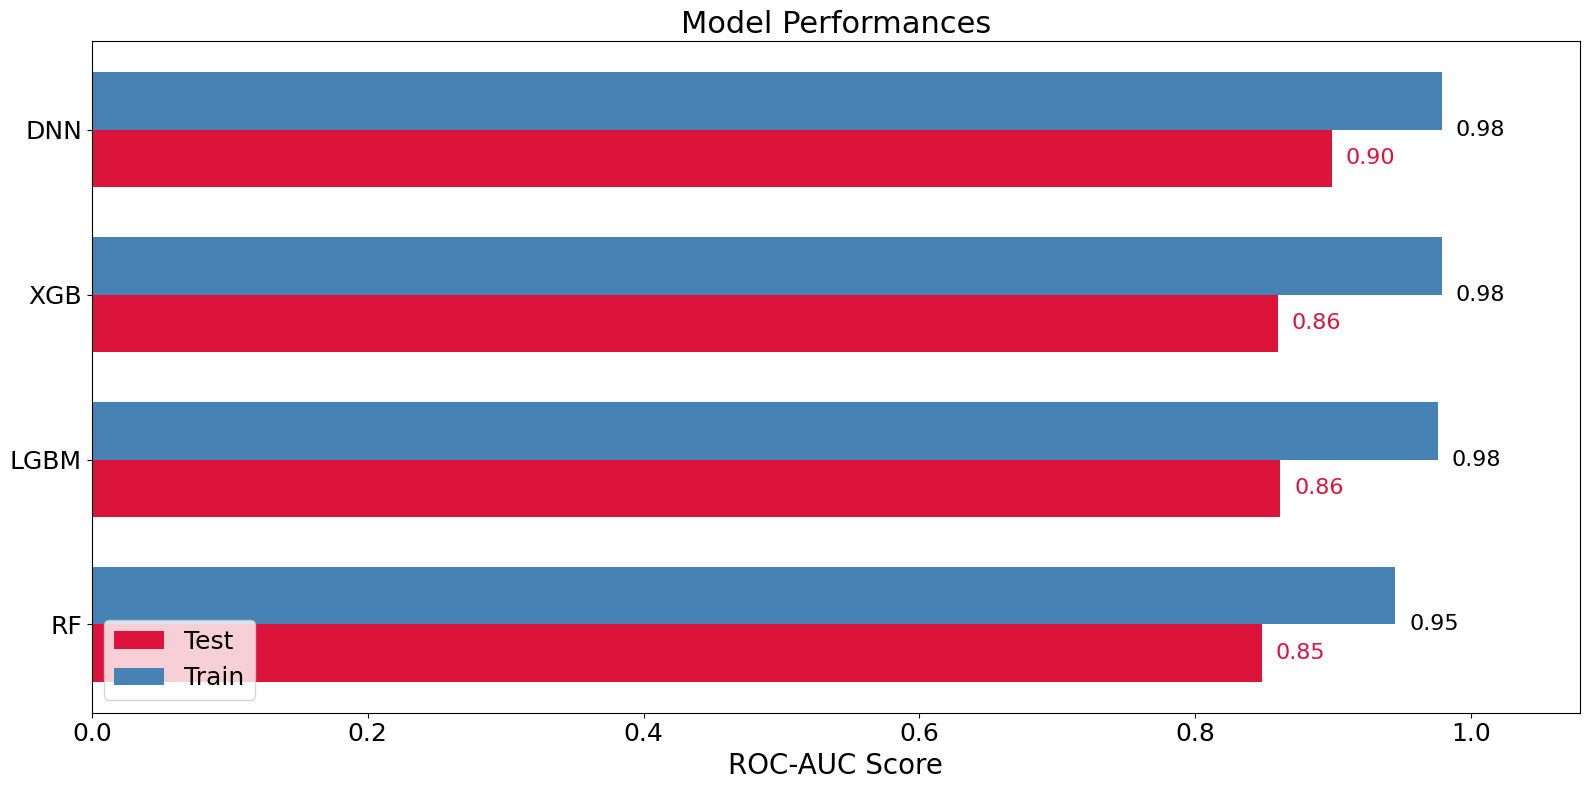

In [15]:
# Append DNN_train_score to train_scores
train_scores.append(DNN_train_score)

# Append DNN_test_score to test_scores
test_scores.append(DNN_test_score)

# Define the algorithm names
classifiers = ['RF', 'LGBM', 'XGB', 'DNN']

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(16, 8))
y_pos = np.arange(len(classifiers))
bar_width = 0.35

# Plot test scores
ax.barh(y_pos, test_scores, bar_width, align='center', color='crimson', label='Test')

# Plot train scores
ax.barh(y_pos + bar_width, train_scores, bar_width, align='center', color='steelblue', label='Train')

# Set y-axis ticks and labels with increased font size
ax.set_yticks(y_pos + bar_width/2)
ax.set_yticklabels(classifiers, fontsize=18)

# Set x-axis tick labels with increased font size
ax.set_xticklabels(ax.get_xticks(), fontsize=18)

# Set x-axis tick labels with increased font size and precision
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.1f}'))

# Set x-axis label and title with increased font size
ax.set_xlabel('ROC-AUC Score', fontsize=20)
ax.set_title('Model Performances', fontsize=22)

# Add annotations to the bars with increased font size
for i, train_score in enumerate(train_scores):
    ax.text(train_score + 0.01, i + bar_width/2, f'{train_score:.2f}', ha='left', va='center', fontsize=16)

for i, test_score in enumerate(test_scores):
    ax.text(test_score + 0.01, i, f'{test_score:.2f}', ha='left', va='center', color='crimson', fontsize=16)

# Adjust the plot limits
max_score = max(max(train_scores), max(test_scores))
ax.set_xlim([0, max_score + 0.1])

# Add legend with increased font size
ax.legend(loc='lower left', fontsize=18)

# Adjust layout to provide space for the legend
plt.tight_layout()

# Display the plot
plt.show()

### 3.7 Save Model

Saving the model and preprocessing steps ensures reproducibility and facilitates seamless deployment, allowing for consistent and efficient utilization of the trained model.

In [16]:
# Save the numerical imputer
dump(num_imputer, "model/num_imputer.joblib")

# Save the scaler object
dump(scaler, "model/scaler.joblib")

# Save the encoder object
dump(encoder, "model/encoder.joblib")

# Save the trained DNN model
model.save("model/trained_model.h5")

### 3.8 Load Model

Loading the model enables easy access to the previously trained model's parameters and functionality, allowing for seamless integration into new applications or tasks.

In [17]:
# Load the numerical imputer
num_imputer = load("model/num_imputer.joblib")

# Load the scaler object
scaler = load("model/scaler.joblib")

# Load the encoder object
encoder = load("model/encoder.joblib")

# Load the trained DNN model
model = load_model("model/trained_model.h5")

### 3.9 Model Prediction

These code snippets allow for generating accurate outputs, enabling making efficient and well-informed lending decisions.

#### Get new input

In [18]:
# Let's test the model inferencing by using first row of df
first_row = df.iloc[[0]] 
first_row = first_row.drop("loan_status", axis=1)  # Drop the loan_status column

first_row.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3


#### Preprocess input

In [19]:
# get numerical and categorical columns
numerical_cols = X_train_numerical.columns 
categorical_cols = X_train_categorical.columns

# Preprocess numerical columns
first_row_imputed_num = pd.DataFrame(num_imputer.transform(first_row[numerical_cols]), columns=numerical_cols, index=first_row.index)
first_row_scaled = pd.DataFrame(scaler.transform(first_row_imputed_num), columns=numerical_cols, index=first_row.index)

# Preprocess categorical columns
first_row_encoded = pd.DataFrame(encoder.transform(first_row[categorical_cols]).toarray(), columns=encoder.get_feature_names_out(categorical_cols), index=first_row.index)

# Combine the preprocessed numerical and categorical columns
first_row_processed = pd.concat([first_row_scaled, first_row_encoded], axis=1)

#### Predict output

In [20]:
# Default threshold value for Tensorflow Neural Nets
threshold = 0.5

# Make prediction using the loaded model
prediction_proba = model.predict(first_row_processed)

# Convert the probability to binary prediction
prediction = 1 if prediction_proba[0][0] > threshold else 0

print("Prediction:", prediction)

1/1 [==============================] - 0s 35ms/step
Prediction: 1


## 4. Conclusion

The DNN model outperformed tree-based models in terms of ROC-AUC scores, indicating remarkable predictive power and generalizability. It was selected for loan default prediction. The developed ML model, trained on provided data, accurately predicts default risk and aids in informed lending decisions. Now that the notebook is developed, we can create an API using FAST API and containerize it using Docker in this project to simplify deployment, enhance accessibility, and enable seamless integration with existing banking systems and workflows.